### Smit Lunagariya
#### Implementation of Weighted Twin Support Vector Regression

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator,RegressorMixin
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
%matplotlib inline

In [2]:
class WeightedTSVR(BaseEstimator,RegressorMixin):
    def __init__(self,c1=10,c2=10,e1=0.01,e2=0.01,kernel='gaussian_kernel',sigma=5,degree=3,regul=0,sai1=1,sai2=1):
        self.c1=c1
        self.c2=c2
        self.e1=e1
        self.e2=e2
        self.kernel=kernel
        self.sigma=sigma
        self.degree=degree
        self.regul=regul
        self.sai1=sai1
        self.sai2=sai2
    def fit(self,X,Y):
        m,n=X.shape
        self.X=X
        Y=np.array(Y).reshape(-1,1)
        f=Y-self.e1
        h=Y+self.e2
        if self.kernel=='gaussian_kernel':
            G=matrix(np.hstack((self.gaussian_kernel(np.array(self.X)),np.ones((m,1)))))
           
        elif self.kernel=='polynomial_kernel':
            G=matrix(np.hstack((self.polynomial_kernel(self.X),np.ones((m,1)))))
          
        else:
            G=matrix(np.hstack((self.linear_kernel(self.X),np.ones((m,1)))))
        [w1,b1]=self.plane1(G,f,m)
        [w2,b2]=self.plane1(G,h,m)
        self.coef_=(w1+w2)/2
        self.intercept_=(b1+b2)/2
        return self
    
    def predict(self,Xi):
        if self.kernel=='gaussian_kernel':
            Xit=self.gaussian_kernel_predict(np.array(Xi))
        elif self.kernel=='polynomial_kernel':
            Xit=self.polynomial_kernel(Xi)
        else:
            Xit=self.linear_kernel(Xi)
        self.pre=np.dot(np.array(Xit),self.coef_).sum(axis=1)+self.intercept_
        return self.pre
        
    def score(self,Xt,yt):
        ypre=self.predict(np.array(Xt))
        return r2_score(np.array(yt),ypre)
    
    def plane1(self,G,f,m):
        Z1=np.dot(G.T,G)
        Z1=Z1+ self.regul*(np.identity(Z1.shape[0]))   
        Z2=np.linalg.solve(Z1,G.T)
        Z3=(np.dot(G,Z2))
        Px=((Z3+Z3.T)/2)
        Pxx=np.hstack((Px,np.zeros((m,m))))
        P1=matrix(np.vstack((Pxx,np.zeros((m,2*m)))))
        q1=matrix(np.hstack((((f.T)-(np.dot(f.T,Px))),self.e1*np.ones((1,m)))).reshape(-1,1))
        sub=np.hstack((np.zeros((m,m)),-1*np.eye(m)))
        constraint1=matrix(np.vstack((np.hstack(((np.vstack((np.eye(m)*-1,np.eye(m)))),np.zeros((2*m,m)))),sub)))
        constraint_ineq1=matrix(np.hstack((np.hstack((np.zeros(m), np.ones(m) *(self.c1*self.sai1))),np.zeros(m))))
        alpha=solvers.qp(P=P1,q=q1,G=constraint1,h=constraint_ineq1)
        z=np.array(alpha['x'])[:m]
        w1=np.dot(Z2,(f-z))[:-1]
        b1=np.dot(Z2,(f-z))[-1]
        return [w1,b1]
    
    def plane2(self,G,h,m):
        Z1=np.dot(G.T,G)
        Z1=Z1+ self.regul*(np.identity(Z1.shape[0]))   
        Z2=np.linalg.solve(Z1,G.T)
        Z3=(np.dot(G,Z2))
        Px=((Z3+Z3.T)/2)
        Pxx=np.hstack((Px,np.zeros((m,m))))
        P2=matrix(np.vstack((Pxx,np.zeros((m,2*m)))))
        q2=matrix(np.hstack((((np.dot(h.T,Px)-(h.T))),self.e2*np.ones((1,m)))).reshape(-1,1))
        sub=np.hstack((np.zeros((m,m)),-1*np.eye(m)))
        constraint2=matrix(np.vstack((np.hstack(((np.vstack((np.eye(m)*-1,np.eye(m)))),np.zeros((2*m,m)))),sub)))
        constraint_ineq2=matrix(np.hstack((np.hstack((np.zeros(m), np.ones(m) *(self.c2*self.sai2))),np.zeros(m))))
        alpha=solvers.qp(P=P2,q=q2,G=constraint2,h=constraint_ineq2)
        z=np.array(alpha['x'])[:m]
        w2=np.dot(Z2,(h+z))[:-1]
        b2=np.dot(Z2,(h+z))[-1]
        return [w2,b2]
    
    def linear_kernel(self,x1):
        return np.dot(x1, (self.X).T)

    def polynomial_kernel(self,x):
        return (1 + np.dot(x, (self.X).T)) ** self.degree

    def gaussian_kernel(self,x):
        K=np.zeros((x.shape[0],x.shape[0]))
        
        for i in range(x.shape[0]):
            
            for j in range(x.shape[0]):
                
                K[i,j]=np.exp(-(np.linalg.norm(np.array(x)[i].reshape(-1,1)-np.array(x)[j].reshape(-1,1))/ (2* (self.sigma** 2))))  
        return K
    def gaussian_kernel_predict(self,Xi):
        K=np.zeros((Xi.shape[0],(self.X).shape[0]))
        for i in range(Xi.shape[0]):
            for j in range((self.X).shape[0]):
                K[i,j]=np.exp(-(np.linalg.norm(np.array(Xi)[i].reshape(-1,1)-np.array(self.X)[j].reshape(-1,1))/ (2* (self.sigma** 2))))
        return K
                            

In [3]:
x=np.linspace(-10.2,10,num=81).reshape(-1,1)
y=np.sin(x)/x
yhat=y+np.random.normal(scale=0.1,size=81).reshape(-1,1)

In [4]:
wsvr=WeightedTSVR(c1=0.10,c2=0.10,e1=10,e2=10,sigma=81,regul=0.0000001,sai1=0.1,sai2=0.1)

In [5]:
wsvr.fit(x,yhat)

     pcost       dcost       gap    pres   dres
 0: -8.1003e+03  9.2417e+02  3e+03  2e+02  1e-01
 1: -7.9829e+01 -8.2153e-01  4e+01  2e+00  1e-03
 2: -7.9900e-01 -8.4808e-01  1e+00  2e-02  1e-05
 3: -5.1611e-02 -8.6357e-02  9e-02  1e-03  8e-07
 4: -2.5854e-02 -3.3979e-02  2e-02  1e-04  1e-07
 5: -2.8160e-02 -2.9672e-02  2e-03  2e-05  1e-08
 6: -2.8778e-02 -2.9023e-02  4e-04  2e-06  1e-09
 7: -2.8908e-02 -2.8919e-02  1e-05  3e-08  2e-11
 8: -2.8915e-02 -2.8915e-02  2e-07  5e-10  3e-13
 9: -2.8915e-02 -2.8915e-02  2e-09  5e-12  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.1003e+03  9.2417e+02  3e+03  2e+02  1e-01
 1: -7.9824e+01 -8.2154e-01  4e+01  2e+00  1e-03
 2: -7.9895e-01 -8.4808e-01  1e+00  2e-02  1e-05
 3: -5.1607e-02 -8.6354e-02  9e-02  1e-03  8e-07
 4: -2.5847e-02 -3.3972e-02  2e-02  1e-04  1e-07
 5: -2.8151e-02 -2.9664e-02  2e-03  2e-05  1e-08
 6: -2.8771e-02 -2.9012e-02  3e-04  2e-06  1e-09
 7: -2.8899e-02 -2.8910e-02  1e-05  4e-08  2e-1

WeightedTSVR(c1=0.1, c2=0.1, degree=3, e1=10, e2=10, kernel='gaussian_kernel',
       regul=1e-07, sai1=0.1, sai2=0.1, sigma=81)

In [6]:
pred=wsvr.predict(x)

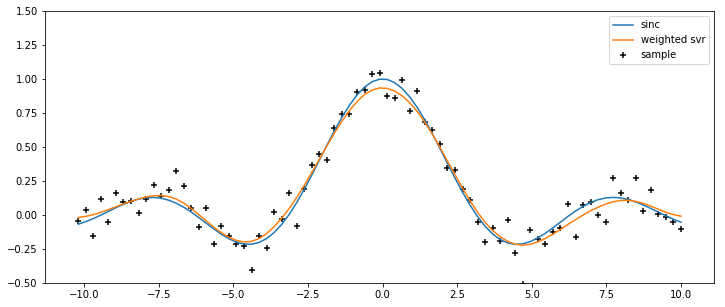

In [7]:
plt.figure(figsize=(12,5))
plt.plot(x,y,label='sinc')
plt.scatter(x,yhat,marker='+',label='sample',color='black')
plt.plot(x,pred,label='weighted svr')
plt.ylim([-0.5,1.5])
plt.legend()

In [8]:
def Evaluation_of_result(y,ypred):
    def mean_abs_error(y,ypred):
        return mean_absolute_error(y,ypred)
    def root_mean_sq_error(y,ypred):
        return math.sqrt(mean_squared_error(y,ypred))
    def SSE(y,ypred):
        y.reshape(-1,1)
        ypred.reshape(-1,1)
        return mean_squared_error(y,ypred)*(y.shape[0])
    def SST(y):
        y.reshape(-1,1)
        return np.var(y)*(y.shape[0])
    def SSR(ypred):
        ypred.reshape(-1,1)
        return np.var(ypred)*(ypred.shape[0])
    print("MAE: ",mean_abs_error(y,ypred))
    print("RMSE: ",root_mean_sq_error(y,ypred))
    print("SSE: ",SSE(y,ypred))
    print("SSR: ",SSR(ypred))
    print("SST: ",SST(y))
    print("SSR/SST: ",SSR(ypred)/SST(y))
    print("SSE/SST: ",SSE(y,ypred)/SST(y))

In [9]:
print("The evaluation of results of Twin SVR are as follows:")
Evaluation_of_result(y,pred)

The evaluation of results of Twin SVR are as follows:
MAE:  0.02859223415342082
RMSE:  0.03375555895026135
SSE:  0.0922944585636101
SSR:  8.973540370058224
SST:  9.942618950174554
SSR/SST:  0.9025328653373248
SSE/SST:  0.009282711026755156
